In [25]:
import string
import uuid
import csv
import logging
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
! pip install seaborn
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from app.io import redshift
from app.io.s3 import write_df
from app.util.env import IS_PRODUCTION
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
# says it should not be used for categorical values but not clear why\n",
from sklearn.preprocessing import LabelEncoder
import re

In [26]:
FORMAT = '%(asctime)s %(message)s'
logging.basicConfig(format=FORMAT)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

root_path = os.environ.get('PYTHONPATH')

if IS_PRODUCTION:
    root_path = "/opt/compute"

In [27]:
# get data for training

# 
# this dataset is much better from november on but includes less fraudulent accounts 
# so we will do more tries
# we need to make sure this is balanced 
query = """
select has_anonymous_id, 
share_invite_link,
country,
len_user_name,
email_domain,
user_name,
browser_tz,
number_pageviews,
utm_medium,
is_fraud as is_suspended

from nuriaruiz_dbt_dev_compute.account_creation_classifier_training_dataset 
where (is_fraud > 0 or (random_marker > 0.99 and received_at > '2022-01-01'))

        """


df = redshift.read(query)

logger.info("Finish Reading data from Redshift")
#print (df.head(5))

redshift.read:
select has_anonymous_id, 
share_invite_link,
country,
len_user_name,
email_domain,
user_name,
browser_tz,
number_pageviews,
utm_medium,
is_fraud as is_suspended

from nuriaruiz_dbt_dev_compute.account_creation_classifier_training_dataset 
where (is_fraud > 0 or (random_marker > 0.99 and received_at > '2022-01-01'))


2023-08-28 06:55:23,039 Finish Reading data from Redshift


label value counts
0    8026
1    4739
Name: is_suspended, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


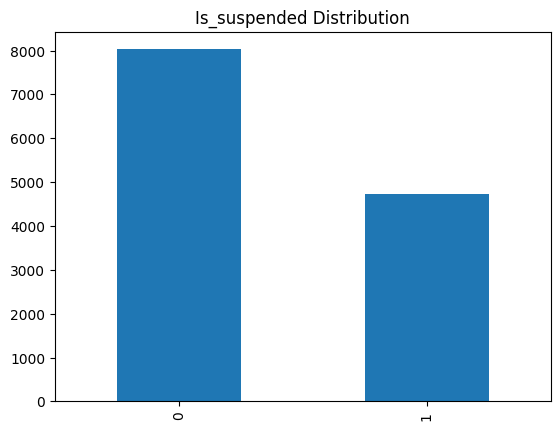

In [28]:
# see how balanced is the variable we are trying to predict
# aim for about 30%
print ("label value counts")
print (df['is_suspended'].value_counts())
print (df['is_suspended'].value_counts().plot(kind='bar', title='Is_suspended Distribution'))

In [29]:
# the user name for fraudulent accounts looks like 'qwrbqw' and similar
# adding here a feature that might provide this signal, we identify the 
# number of 4 consonant groups on a user name and add the number of them we find as a feature
# example 'Chaiyuth Tangsurakit' has zero 4 consonant groups
# and 'db sdb sdbsdb' has two
# this only works for western names !!!!!
# we use a large number for empty names

consonant_groups = []

for user_name in df['user_name']:
    
    if user_name is None:
        consonant_groups.append(10)
    else:
        #print (user_name)
        tally = []
        user_name= user_name
        for u in user_name.split():
            finds = (re.findall(r'[^aeiouy]{4,}', u))
            if len(finds)!= 0:
                tally.append(finds)
        consonant_groups.append(len(tally))
        


df['user_name_consonant_groups'] = consonant_groups



In [30]:
#for c in df['user_name_consonant_groups']:
#    if c > 1:
#        print(c)

In [31]:
print ("Value counts")
print (df['country'].value_counts())
print(df['email_domain'].value_counts())


# label encoding for categorical features
le = LabelEncoder()
for col in ('country', 'browser_tz', 'utm_medium', 'email_domain', 'user_name'):
    df[col]=le.fit_transform(df[col])

    
#print ("Max min country")
#print (max(df['country']))
#print (min(df['country']))





Value counts
US    7237
CA     753
KR     289
GB     236
TH     212
      ... 
BQ       1
JE       1
SL       1
FK       1
LT       1
Name: country, Length: 159, dtype: int64
gmail.com                   7500
yahoo.com                   1121
hotmail.com                  684
outlook.com                  482
privaterelay.appleid.com     403
                            ... 
rebation.com                   1
perry.kyschools.us             1
thesimplestartup.com           1
aceacademyarkansas.com         1
stgeorgeclinic.org             1
Name: email_domain, Length: 1166, dtype: int64


In [33]:
# make sure to drop the predicted variable
target = df['is_suspended']
features = df.drop('is_suspended', axis=1)

print (features.head(2))


# turns out that sklearn train_test_split does not work so great 
from sklearn.model_selection import GroupShuffleSplit

# You can change the test_size below (ideally between 0.2-0.4)
train_indices, test_indices = next(GroupShuffleSplit(test_size=0.30, random_state = 7).split(features,  groups=features['country']))

x_train = features.iloc[train_indices]
y_train = target[train_indices]

print (train.head())

x_test = features.iloc[test_indices]
y_test = target[test_indices]

print (test.head())

# use 80% of data for training, random_state controls the shuffle of data before it is passed to training set
#x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.75,test_size=0.25)
# scale all below 1 with  x_scaled = (x-x_min)/X_max-X_min
min_max_scaler = MinMaxScaler()


# we want to scale training set and testing set separately
# to avoid data leakage
# https://machinelearningmastery.com/data-preparation-without-data-leakage/
x_train_min_max = min_max_scaler.fit_transform(x_train)
x_test_min_max = min_max_scaler.fit_transform(x_test)


   has_anonymous_id  share_invite_link  country  len_user_name  email_domain  \
0                 0                  0      159             33          1134   
1                 0                  0      159              7           371   

   user_name  browser_tz  number_pageviews  utm_medium  \
0       1223          54               0.0          20   
1       7425          44               0.0          20   

   user_name_consonant_groups  
0                           2  
1                           0  
     has_anonymous_id  share_invite_link  country  len_user_name  \
172                 0                  0      149             13   
200                 0                  0      149              6   
202                 0                  0      149             14   
203                 0                  0      149             15   
204                 0                  0      149             18   

     email_domain  user_name  browser_tz  number_pageviews  utm_medium  \
172  

In [ ]:
print (x_test_min_max[4:6])
print (y_test[4:6])
print(df[4:6])

<AxesSubplot:>

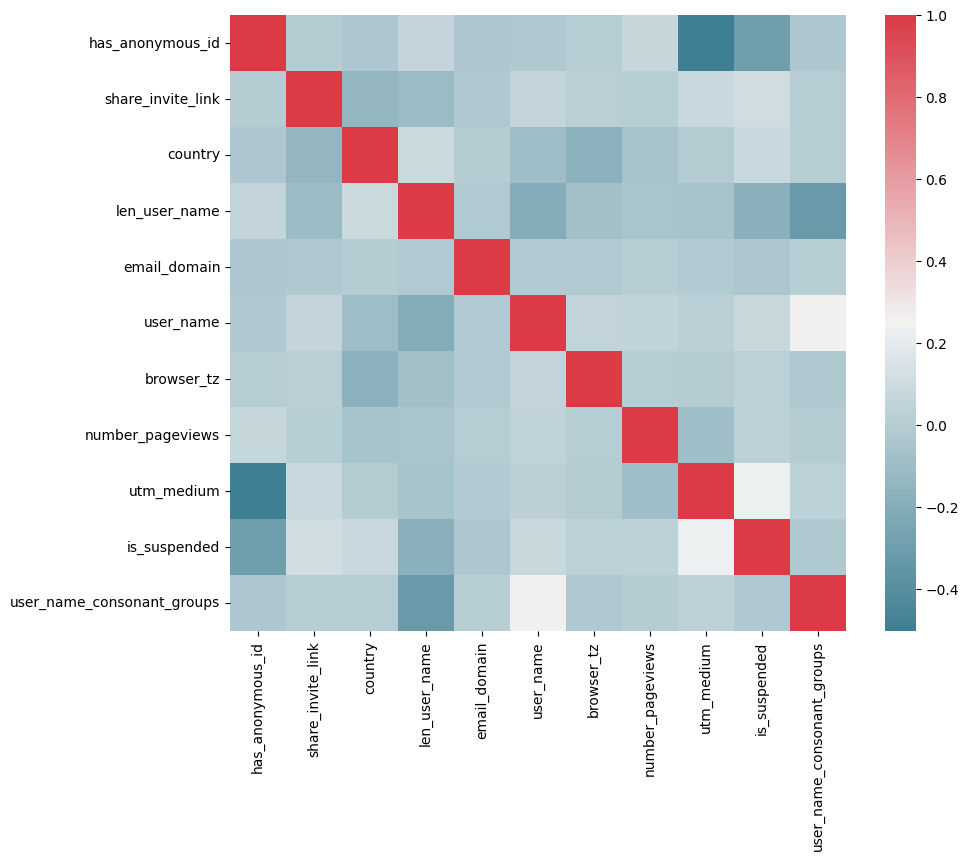

In [34]:
# correlation matrix among two variables, remove variables highly correlated
# more ways to identify relationships:
# https://medium.com/geekculture/feature-selection-in-machine-learning-correlation-matrix-univariate-testing-rfecv-1186168fac12
#plt.matshow(x_train.corr())
#plt.show()

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [ ]:

# Fit a logistic regression model to the data
model = LogisticRegression()
model.fit(x_train_min_max, y_train)


# this is a fraudulent record of testing set
p = model.predict([[0, 0, 1, 0,  0.32979852, 1,0.27419355, 0, 1,  1 ]])
print(p)


In [ ]:
# Predict the fraudulent transactions on the test data
print (x_test_min_max)

predictions = model.predict(x_test_min_max).round()
#print(predictions)
#print (y_test)

# more metrics here: 
#https://medium.com/@oluwabukunmige/logistic-regression-in-scikit-learn-a-step-by-step-process-32f546241f32

# Evaluate the model on the the data
# returns mean of accuracy (average of wrong or right per sample)
# careful, if there is data imbalance and you have few fraud samples 
# accuracy could be high but still you cannot predict
print("Score training data:")
print(model.score(x_train_min_max, y_train))
print("Score test data:")
print (model.score(x_test_min_max, y_test))

In [ ]:
#  TP FP
#  FN TN
#confusion = confusion_matrix(x_test_min_max, predictions)
#print(confusion)
print(classification_report(y_test, predictions, target_names=['0', '1']))


In [ ]:
logger.info("DONE")